### Data Analysis project to Rize
Objective: Create a predictive model that forecasts tenant payment behavior based on past data.

In [155]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load and Inspect Data from Kaggle that shows multiple info that can be used later to our predictve model
https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset

BHK: Number of Bedrooms, Hall, Kitchen.

Rent: Rent of the Houses/Apartments/Flats.

Size: Size of the Houses/Apartments/Flats in Square Feet.

Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

Area Locality: Locality of the Houses/Apartments/Flats.

City: City where the Houses/Apartments/Flats are Located.

Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

Bathroom: Number of Bathrooms.

Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

In [157]:
rent_data = pd.read_csv('House_Rent_Dataset.csv')


rent_data.head()


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### Generate Synthetic Data (Salaries, Payment Status, etc.)
Explanation:
We generate synthetic data like salaries, payment status, and days late because the original dataset likely lacks these variables, which are crucial for predicting tenant payment behavior

In [159]:
# Function to generate synthetic salary based on rent
def generate_salary(rent):
    return rent * np.random.uniform(2.5, 5)

# Generate salary based on rent
rent_data['Salary'] = rent_data['Rent'].apply(generate_salary).astype(int)

# Simulate payment status (80% on time, 20% late)
rent_data['Payment_Status'] = np.random.choice([0, 1], size=len(rent_data), p=[0.8, 0.2])

# Generate synthetic "Days Late" (if Payment_Status is late, random between 1-10 days)
rent_data['Days_Late'] = [random.randint(1, 10) if status == 1 else 0 for status in rent_data['Payment_Status']]

# Rent-to-Income Ratio
rent_data['Rent_to_Income_Ratio'] = rent_data['Rent'] / rent_data['Salary']

# Simulate "Payment Date"
due_date = datetime(2024, 9, 1)
rent_data['Payment_Date'] = [due_date + timedelta(days=delay) if status == 1 else due_date 
                             for status, delay in zip(rent_data['Payment_Status'], rent_data['Days_Late'])]


In [161]:
# Display the final dataframe
rent_data.head()

# Export to a CSV if needed
rent_data.to_csv('synthetic_rent_data.csv', index=False)


## Exploratory Data Analysis

#### Histogram for Salary Distribution

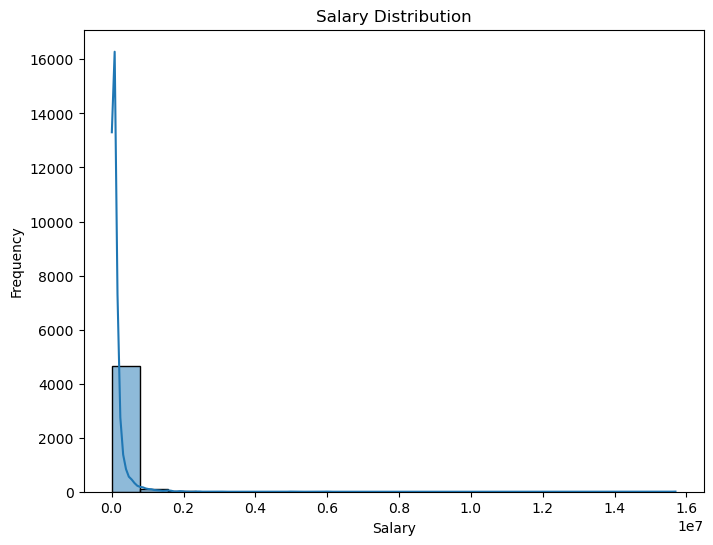

In [163]:
plt.figure(figsize=(8, 6))
sns.histplot(rent_data['Salary'], bins=20, kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

#### Box Plot of Rent-to-Income Ratio by Cityhow()


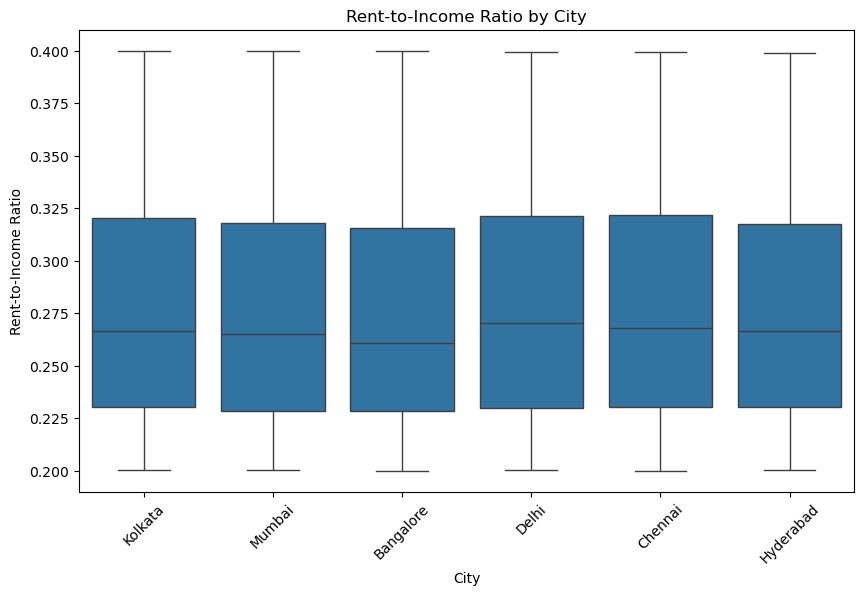

In [165]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='City', y='Rent_to_Income_Ratio', data=rent_data)
plt.xticks(rotation=45)
plt.title('Rent-to-Income Ratio by City')
plt.xlabel('City')
plt.ylabel('Rent-to-Income Ratio')
plt.show()

#### Scatter Plot of Rent-to-Income Ratio vs Payment Status

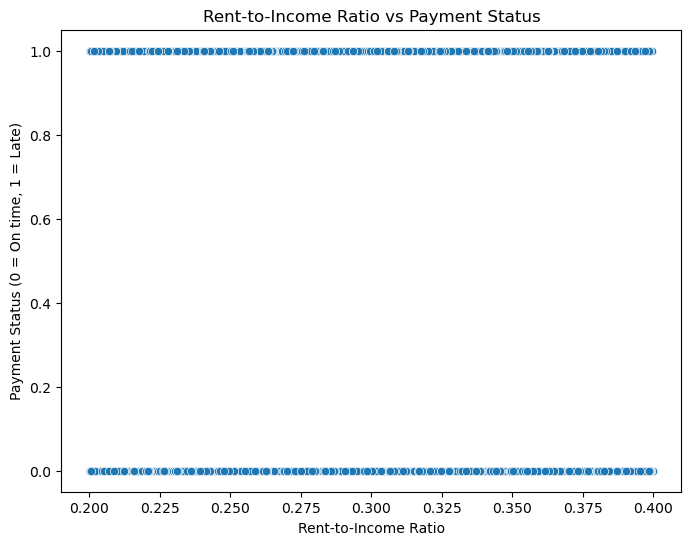

In [167]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Rent_to_Income_Ratio', y='Payment_Status', data=rent_data)
plt.title('Rent-to-Income Ratio vs Payment Status')
plt.xlabel('Rent-to-Income Ratio')
plt.ylabel('Payment Status (0 = On time, 1 = Late)')
plt.show()

#### Distribution of Days Late for Late Payments

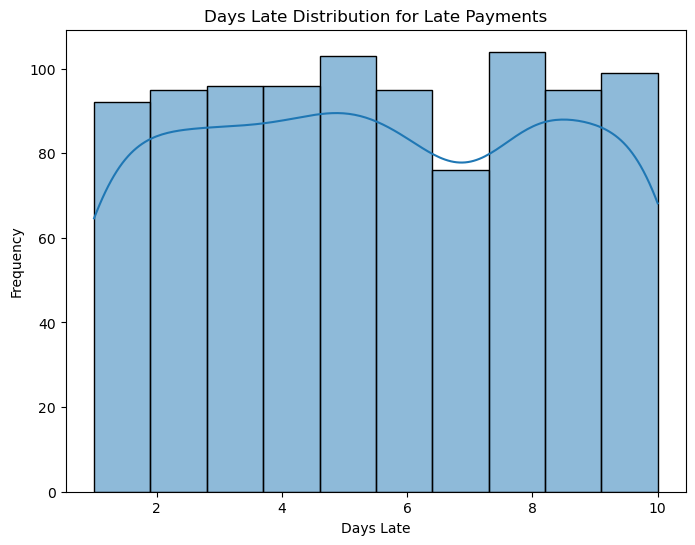

In [169]:
late_payments = rent_data[rent_data['Payment_Status'] == 1]
plt.figure(figsize=(8, 6))
sns.histplot(late_payments['Days_Late'], bins=10, kde=True)
plt.title('Days Late Distribution for Late Payments')
plt.xlabel('Days Late')
plt.ylabel('Frequency')
plt.show()


# build a prediction model to forecast whether a tenant will pay on time or late based on features like rent, salary, rent-to-income ratio

In [171]:
#prepare the data
# Features (independent variables)
X = rent_data[['Rent', 'Salary', 'Rent_to_Income_Ratio', 'BHK']]

# Target (dependent variable)
y = rent_data['Payment_Status']  # 0 = On time, 1 = Late

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [173]:
#Train a Logistic Regression Model
# Initialize the model
model = LogisticRegression()

# Train the model with resampled data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.628421052631579
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75       777
           1       0.20      0.34      0.25       173

    accuracy                           0.63       950
   macro avg       0.51      0.52      0.50       950
weighted avg       0.71      0.63      0.66       950



# Testing the model

In [181]:
# Sample input data for a new tenant
new_tenant1 = pd.DataFrame({
    'Rent': [15000],
    'Salary': [50000],
    'Rent_to_Income_Ratio': [15000/50000],
    'BHK': [2]
})
new_tenant2 = pd.DataFrame({
    'Rent': [30000],
    'Salary': [40000],
    'Rent_to_Income_Ratio': [30000/40000],
    'BHK': [2]
})

tenants = [new_tenant1, new_tenant2]

for i, tenant in enumerate(tenants, start=1):
    prediction = model.predict(tenant)
    
    # Output the result
    if prediction == 1:
        print(f"Tenant {i} is predicted to be late.")
    else:
        print(f"Tenant {i} is predicted to be on time.")

Tenant 1 is predicted to be on time.
Tenant 2 is predicted to be late.


## Model Accuracy

In [183]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the predictive model
accuracy = accuracy_score(y_test, y_pred)

# Convert accuracy to percentage
accuracy_percentage = accuracy * 100
print(f"Model accuracy: {accuracy_percentage:.2f}%")


Model accuracy: 62.84%
